<a href="https://colab.research.google.com/github/mohammedala/retina-blood-vessel-segmentation/blob/main/retina_blood_vessel_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset from Kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download abdallahwagih/retina-blood-vessel
! unzip /content/retina-blood-vessel.zip

# Set the seeds and TPU

In [ ]:
import numpy as py
import matplotlib.pyplot as plt
import cv2 as cv
import gc
import random
import os
import tensorflow as tf

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
seed_value = 42
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
random.seed(seed_value)
py.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Load the dataset

In [ ]:
def load_data (split = "train"):
    x = []
    y = []
    for i in os.listdir(f"/content/Data/{split}/image"):
        x.append(tf.cast(cv.imread(f"/content/Data/{split}/image/"+i), tf.float32)/255.0)
        y.append(tf.cast(cv.imread(f"/content/Data/{split}/mask/"+i), tf.float32)/255.0)
    return py.array(x), py.array(y)

In [ ]:
x_train, y_train = load_data (split = "train")
x_test, y_test = load_data (split = "test")

In [ ]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test:",x_test.shape)
print("y_test:",y_test.shape)

x_train: (80, 512, 512, 3)
y_train: (80, 512, 512, 3)
x_test: (20, 512, 512, 3)
y_test: (20, 512, 512, 3)


# Model Architecture

In [ ]:
def conv_block(inputs, n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(inputs, n_filters):
    skip = conv_block(inputs, n_filters)
    x = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, x


def decoder_block(inputs,skip, n_filters):
    x = tf.keras.layers.Conv2DTranspose(n_filters, (2,2), padding = "Same", strides = 2)(inputs)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = conv_block(x, n_filters)
    return x


def unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    #encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    #middle
    m1 = conv_block(p4, 1024)
    m2 = conv_block(m1, 512)
    m3 = conv_block(m2, 1024)

    #decoder
    p5 = decoder_block(m3,s4 ,512)
    p6 = decoder_block(p5,s3 ,256)
    p7 = decoder_block(p6,s2 ,128)
    p8 = decoder_block(p7,s1 ,64)

    outputs = tf.keras.layers.Conv2D(3, 3, padding = "same", activation = "sigmoid")(p8)
    model = tf.keras.Model(inputs, outputs, name="U-Net")
    return model

# Setting parameters and Loss function

In [ ]:
input_shape = x_train.shape[1:]
lr=1e-4

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1e-15
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true*y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, min_lr=1e-7, patience=20, verbose=1),
]

# Model train with TPU

In [ ]:
with tpu_strategy.scope():
    # Define and compile your model
    model = unet(input_shape)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr), loss = dice_loss, metrics = [dice_coef])
    history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 500, batch_size=8)

Epoch 1/500
10/10 [==============================] - 93s 4s/step - loss: 0.8046 - dice_coef: 0.1954 - val_loss: 0.8506 - val_dice_coef: 0.2911
Epoch 2/500
10/10 [==============================] - 4s 401ms/step - loss: 0.7480 - dice_coef: 0.2520 - val_loss: 0.8517 - val_dice_coef: 0.2902
Epoch 3/500
10/10 [==============================] - 3s 358ms/step - loss: 0.7030 - dice_coef: 0.2970 - val_loss: 0.8533 - val_dice_coef: 0.2889
Epoch 4/500
10/10 [==============================] - 4s 369ms/step - loss: 0.6606 - dice_coef: 0.3394 - val_loss: 0.8558 - val_dice_coef: 0.2868
Epoch 5/500
10/10 [==============================] - 4s 387ms/step - loss: 0.6153 - dice_coef: 0.3847 - val_loss: 0.8591 - val_dice_coef: 0.2841
Epoch 6/500
10/10 [==============================] - 4s 362ms/step - loss: 0.5680 - dice_coef: 0.4320 - val_loss: 0.8632 - val_dice_coef: 0.2807
Epoch 7/500
10/10 [==============================] - 4s 364ms/step - loss: 0.5218 - dice_coef: 0.4782 - val_loss: 0.8678 - val_dice_

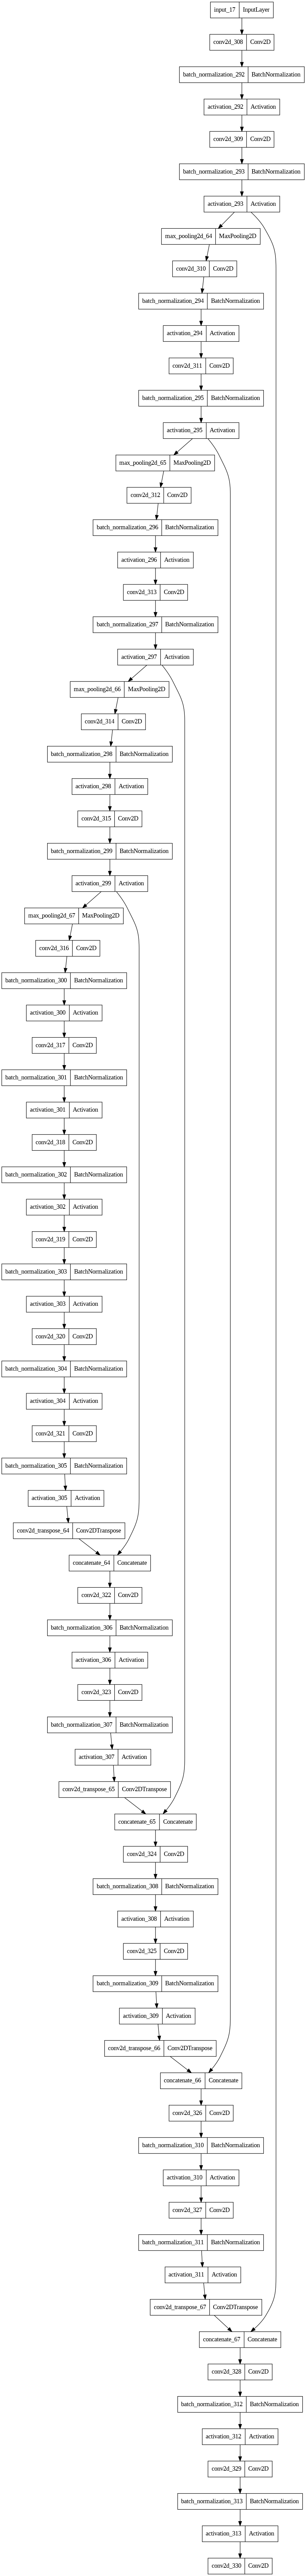

In [ ]:
tf.keras.utils.plot_model(model)

# Model Evaluation

In [ ]:
model.evaluate(x_train, y_train)

3/3 [==============================] - 17s 172ms/step - loss: 0.2276 - dice_coef: 0.7744


[0.22761206328868866, 0.7744129300117493]

In [ ]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 17s 17s/step - loss: 0.2584 - dice_coef: 0.7701


[0.25841960310935974, 0.7700814008712769]

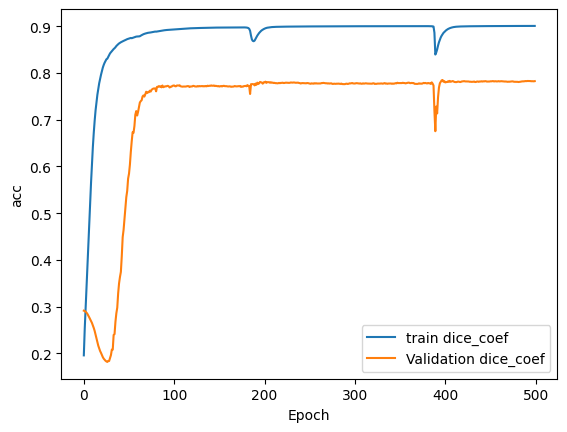

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.xlabel("Epoch")
plt.ylabel("acc")
plt.legend(["train dice_coef","Validation dice_coef"])
plt.show()

# Testing on a sample of train data

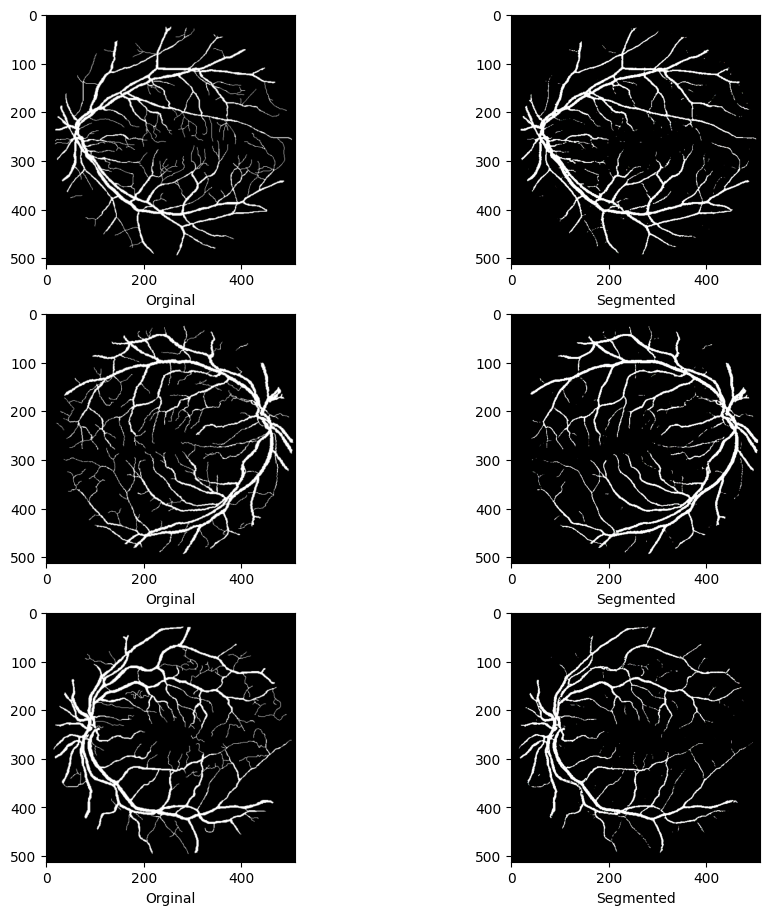

In [ ]:
fig, ax = plt.subplots(3,2)
for i in range(3):
  ax[i][1].imshow((model.predict( x_train[i].reshape((1, 512, 512, 3)), verbose=0))[0])
  ax[i][0].imshow(cv.cvtColor(y_train[i], cv.COLOR_BGR2RGB))
  ax[i][0].set(xlabel="Orginal")
  ax[i][1].set(xlabel="Segmented")
fig.set_size_inches([11,11])
plt.show()

# Testing on a sample of test data

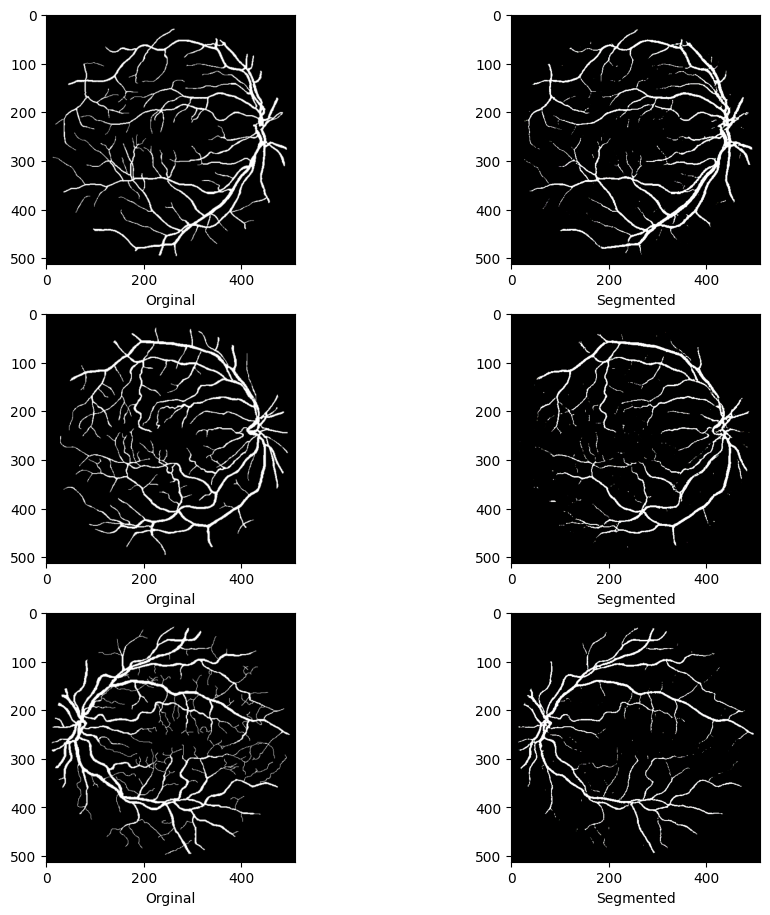

In [ ]:
fig, ax = plt.subplots(3,2)
for i in range(3):
  ax[i][1].imshow((model.predict( x_test[i].reshape((1, 512, 512, 3)), verbose=0))[0])
  ax[i][0].imshow(cv.cvtColor(y_test[i], cv.COLOR_BGR2RGB))
  ax[i][0].set(xlabel="Orginal")
  ax[i][1].set(xlabel="Segmented")
fig.set_size_inches([11,11])
plt.show()